## Discriminative approach to linear-regression

This notebook demonstrates the advantage of the discriminative approach over the generative approach for 
linear regression with additive heavy tail noise.

In [247]:
%pylab inline

import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### constructing a heavy-tail distribtion 

We use the heavy tailed distribution $\frac{1}{x^2+\epsilon}$ for some small $\epsilon>0$

The CDF of this disstribution is
$$F(x)=\frac{1}{\pi} \text{atan}\left( \frac{x}{\sqrt{\epsilon}}\right) + \frac{1}{2}$$

The inverse of the cdf is
$$\mbox{invCDF}(p) = - \frac{\cos(\pi p)}{\sin(\pi p)} \sqrt{\epsilon}$$

To get a sample from this distribution we sample numbers uniformly in $[0,1]$ and pass them through invCDF

In [248]:
epsilon=0.1
g=0.001
P=arange(g,1-g,g)

invCdf=-(cos(pi*P)/sin(pi*P))*sqrt(epsilon)

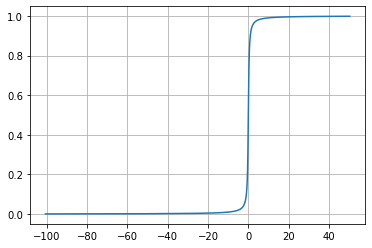

In [249]:
plot(invCdf,P)
grid();

In [250]:
def HTnoise(epsilon=0.1,g=0.001,size=1):
    P=arange(g,1-g,g)
    invCdf=-(cos(pi*P)/sin(pi*P))*sqrt(epsilon)

    S=random.uniform(size=size)

    a=np.int0(S/g)
    #correct for the fact that we trimmed off P=0, P=1
    a=a-1
    a[a<0]=0
    a[a>(P.shape[0]-1)]=P.shape[0]-1

    HT=invCdf[a]
    return HT

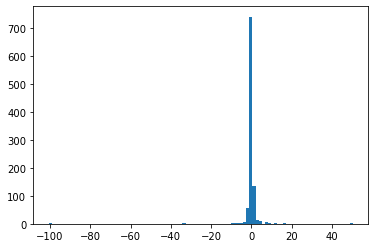

In [251]:
HT=HTnoise(size=1000)
hist(HT,bins=100);

## Generate data and fit using least squares

Slope=5.33382758533036, offset=-4.865163822888357, error=314769741.580849


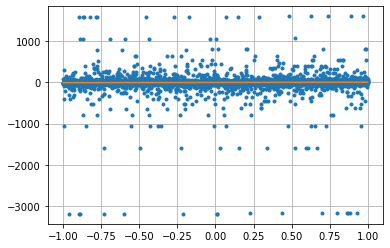

In [394]:
n=10000
Normal_Noise=random.normal(scale=0.1,size=n)
HT_Noise=HTnoise(epsilon=100,size=n)
x=random.uniform(low=-1,high=1,size=n)

#y=10*x+Normal_Noise
y=10*x+HT_Noise

plot(x,y,'.')
M=np.vstack([x, np.ones(len(x))]).T
LSQ_Sol=np.linalg.lstsq(M, y, rcond=None)
a,b=LSQ_Sol[0]
error=LSQ_Sol[1][0]
print(f'Slope={a}, offset={b}, error={error}')
Lx=array([-1,1])
Ly=a*Lx+b
plot(Lx,Ly)
grid()

## Generate background data
to be used as negative examples.

(-1000.0, 1000.0)

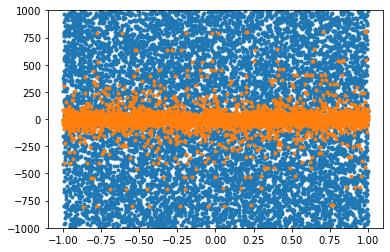

In [395]:
xneg=random.uniform(low=-1,high=1,size=n)
yneg=random.uniform(low=-1000,high=1000,size=n)
plot(xneg,yneg,'.')
plot(x,y,'.')
ylim([-1000,1000])

In [396]:
#pack as a pandas Dataframe
X=np.concatenate([x,xneg])
Y=np.concatenate([y,yneg])
L=np.concatenate([ones(n),-ones(n)])
W=ones(2*n)/(2*n)
data=pd.DataFrame({'X':X,'Y':Y,'L':L,'W':W})

## Fit a tube using classification error

The plan is to sample a small number of points, fit a line using LSQ, and then generate a cdf to see if we can fit a tube with that slope to the data.

In [397]:
def weak_learner(data,weights,n,sz=3,figures=False):
    #extract positive and negative examples separately
    L=copy(data['L'])
    x=copy(data[L==1]['X'])
    y=copy(data[L==1]['Y'])
    xneg=copy(data[L==-1]['X'])
    yneg=copy(data[L==-1]['Y'])
    
    indices=random.permutation(n)[:sz]
    xs=x[indices]
    ys=y[indices]
    Ms=np.vstack([xs, np.ones(len(xs))]).T
    slope=np.linalg.lstsq(Ms, ys, rcond=None)[0][0]

    V=slope*x-y
    Vneg=slope*xneg-yneg
    
    Vlabeled=np.vstack([V, np.ones(len(V))])
    VnegLabeled=np.vstack([Vneg, - np.ones(len(Vneg))])

    AllEx=concatenate([Vlabeled.T,VnegLabeled.T])

    if figures:
        hist(V,bins=100);
        hist(Vneg,bins=100);
        title('hist of pos and neg on projection')
        figure()
        sV=sort(V)
        pp=arange(0,1,1/sV.shape[0])
        plot(sV,pp)
        sVneg=sort(Vneg)
        plot(sVneg,pp)
        title('cumsum of positive and negative on projection')
        grid()
        figure()

    AllEx=AllEx[AllEx[:,0].argsort()]

    C=cumsum(AllEx[:,1])

    _min=argmin(C)
    _max=argmax(C)

    offset1=AllEx[_min,0]
    offset2=AllEx[_max,0]

    allV=np.concatenate([V,Vneg])
    pred=2*(allV>offset1)*(allV<offset2)-1
    correct=pred*L
    err=mean(correct==-1)

    
    return {'slope':slope,'offset1':offset1,'offset2':offset2,'correct':correct,'err':err}

In [398]:
Res=weak_learner(data,data['W'],n)
Res['err']

0.0794

In [402]:
results=[]
for i in range(30):
    result=weak_learner(data,data['W'],n)
    results.append(result)
    
best=argmin([result['err'] for result in results])
best_result = results[best]
err=best_result['err']
err,0.5*log((1-err)/err)

(0.0779, 1.2356138623341966)

(-400.0, 400.0)

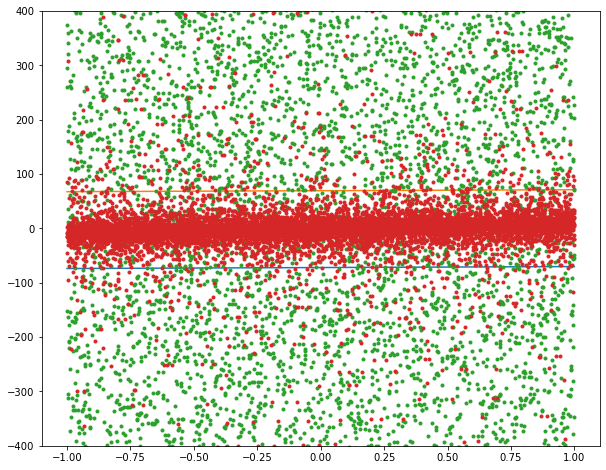

In [403]:
slope=best_result['slope']
figure(figsize=[10,8])
Ly=slope*Lx+best_result['offset1']
plot(Lx,Ly)
Ly=slope*Lx+best_result['offset2']
plot(Lx,Ly)

plot(xneg,yneg,'.')
plot(x,y,'.');
ylim([-400,400])

In [404]:
best_result

{'slope': 1.7979316538214833,
 'offset1': -72.07598755901097,
 'offset2': 69.28039832565804,
 'correct': array([ 1.,  1.,  1., ...,  1.,  1., -1.]),
 'err': 0.0779}

## Conclusions

In this example the tails are so heavy that it is impossible to find the right slope unless you know the distribution of the noise.

The discriminative solution is a tube with small classification error, even though it does not find the correct slope.

This classifier is so accurate that it probably makes little sense to perform more boosting iterations. However, if the data significantly deviates from the tube, we might be able to use more flexible weak classifier to capture that.

In [246]:
#change weights and check that advantage dissappears.
